# Analyzing Inc 5000 2018 Data

This notebook perform some exploratory analysis on data extracted from https://www.inc.com/inc5000/list/2018 which is the list of inc5000 fastest growing companies in 2018. The script used to collect this data is [gatherData.py](https://github.com/eila-elyas/Inc5000-Analysis/blob/master/gatherData.py).

## Import the modules

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
%matplotlib inline

## Reading the sqlite database 

The [gatherData.py](https://github.com/eila-elyas/Inc5000-Analysis/blob/master/gatherData.py) script exports the data to a sqlite database after collecting the data. The code below reads the data from the sqlite database.

In [2]:
conn = sqlite3.connect("inc2018.db")
df = pd.read_sql_query("SELECT * FROM company;", conn)

Top 10 Rows in the Data Set

In [3]:
display(HTML(df.head(10).to_html()))

,index,Rank,CompanyName,Leadership,2017Revenue,Industry,Founded,Growth,Location,Employees
0,0,#1,SwanLeap,Brad Hollister,$99 M,Logistics & Transportation,2013,"75,661%","Madison, WI",49
1,1,#2,PopSockets,David Barnett,$168.8 M,Consumer Products & Services,2010,"71,424%","Boulder, CO",118
2,2,#3,Home Chef,Patrick Vihtelic,$255 M,Food & Beverage,2013,"60,166%","Chicago, IL",865
3,3,#4,Velocity Global,Ben Wright,$49.2 M,Business Products & Services,2013,"39,817%","Denver, CO",78
4,4,#5,DEPCOM Power,Jim Lamon,$219.6 M,Energy,2013,"38,963%","Scottsdale, AZ",104
5,5,#6,Aeronux Airways,Dr. Kambiz Khadem,$21.9 M,Logistics & Transportation,2011,"20,005%","Marietta, GA",17
6,6,#7,Diamond Assets,Mike McKenna,$43.1 M,Computer Hardware,2014,"19,718%","Milton, WI",41
7,7,#8,GForce Life Sciences,Mark Gallagher,$16.9 M,Health,2013,"16,427%","Chicago, IL",13
8,8,#8,Flexport,Ryan Petersen,$224.7 M,Logistics & Transportation,2013,"15,911%","San Francisco, CA",Large (250 - 499)
9,9,#9,Scientist.com,Kevin Lustig,$50.3 M,Health,2007,"15,268%","Solana Beach, CA",Medium (50 - 99)


# Munging the data set

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 10 columns):
index          4999 non-null int64
Rank           4999 non-null object
CompanyName    4999 non-null object
Leadership     4999 non-null object
2017Revenue    4999 non-null object
Industry       4999 non-null object
Founded        4999 non-null object
Growth         4999 non-null object
Location       4999 non-null object
Employees      4999 non-null object
dtypes: int64(1), object(9)
memory usage: 390.6+ KB


For any attribute in which the script is not able to find the html tag it is looking for, the script outputs "couldn't find". Below I will look for all rows in which the script was not able to find an attribute.

In [53]:
cant_find = df[df.apply(lambda row: row.astype(str).str.contains("couldn't find").any(), axis=1)]
diplay(cant_find)

,index,Rank,CompanyName,Leadership,2017Revenue,Industry,Founded,Growth,Location,Employees
71,71,couldn't find,ConvertKit,"Nathan Barry, 27",couldn't find,Software,2013,couldn't find,"Boise, ID",30
267,267,couldn't find,Stukent,Stuart Draper,couldn't find,Education,2013,couldn't find,"Idaho Falls, ID",48
414,414,couldn't find,Lync America,Cynthia Lee,couldn't find,Logistics & Transportation,2014,couldn't find,"Chattanooga, TN",27
997,997,couldn't find,Proximity Learning Inc.,Evan Erdberg,couldn't find,Education,2009,couldn't find,"Austin, TX",150
1339,1339,couldn't find,404 Page Not Found,couldn't find,couldn't find,couldn't find,couldn't find,couldn't find,couldn't find,couldn't find
1569,1569,couldn't find,pNeo,Peter Wenham,couldn't find,Consumer Products & Services,2008,couldn't find,"Denton, TX",15
1693,1693,couldn't find,KingPay,Ron Singh,couldn't find,Financial Services,2013,couldn't find,"London , United Kingdom",50
2251,2251,couldn't find,404 Page Not Found,couldn't find,couldn't find,couldn't find,couldn't find,couldn't find,couldn't find,couldn't find
2351,2351,couldn't find,Greenback Tax Services,Carrie McKeegan,couldn't find,Financial Services,2008,couldn't find,"Mong Kok, Hong Kong",50
2485,2485,couldn't find,EvoText,Johanna Wetmore,couldn't find,Software,2014,couldn't find,"Burlington, MA",Small (25 - 49)


There are 16 company profiles in which the script was not able to extract at least one of the fields. 

The reason that the script was not able to find some of the data is because of inconsistencies in the company profiles. For example, in the image below, you can see that revenue is presented in multiple ways.
![title](revenue.png)

Fortunately, the script was able to capture all the data for all but 16 companies. In order to make sure the script is able to collect all the information, I would have to account for these inconsistencies. For now, I will remove these from the data set.

In [54]:
df2 = df.drop(cant_find.index, axis = 0)

We need to convert some of the attributes to numeric data types. These attributes are '2017Revenue', 'Growth', 'Founded', and 'Employees'. 

In [55]:
df2["Revenue"] = pd.to_numeric(df2["2017Revenue"].apply(lambda x: 0 if x == "couldn't find" else x[1:-2]))

df2["Founded"] = pd.to_numeric(df2["Founded"].apply(lambda x: 0 if x == "couldn't find" else x))

df2["GrowthPercent"] = pd.to_numeric(df2.Growth.apply(lambda x: 0 if x == "couldn't find" else x[:-1].replace(',', '')))

Some of the values in the 'Employees' attribute are provided as a range, which you can see below. In order to convert the 'Employees' attribute to numeric, I will extract the upper number provided in the range for these types of values.

In [56]:
df2.iloc[9]

index                            9
Rank                            #9
CompanyName          Scientist.com
Leadership            Kevin Lustig
2017Revenue                $50.3 M
Industry                    Health
Founded                       2007
Growth                     15,268%
Location          Solana Beach, CA
Employees        Medium  (50 - 99)
Revenue                       50.3
GrowthPercent                15268
Name: 9, dtype: object

To extract the upper value in the Employee counts provided as a range.

In [57]:
def dash(s):
    if s.find("-") != -1:
        return s[s.find("- ") + 2:-1]
    else:
        return s
df2["EmployeeUpdate"] = df2.Employees.apply(dash)
df2["EmployeeUpdate"] = pd.to_numeric(df2.EmployeeUpdate.apply(lambda x: 0 if x == "couldn't find" else x))

## Plots

### Number of Companies per Industry

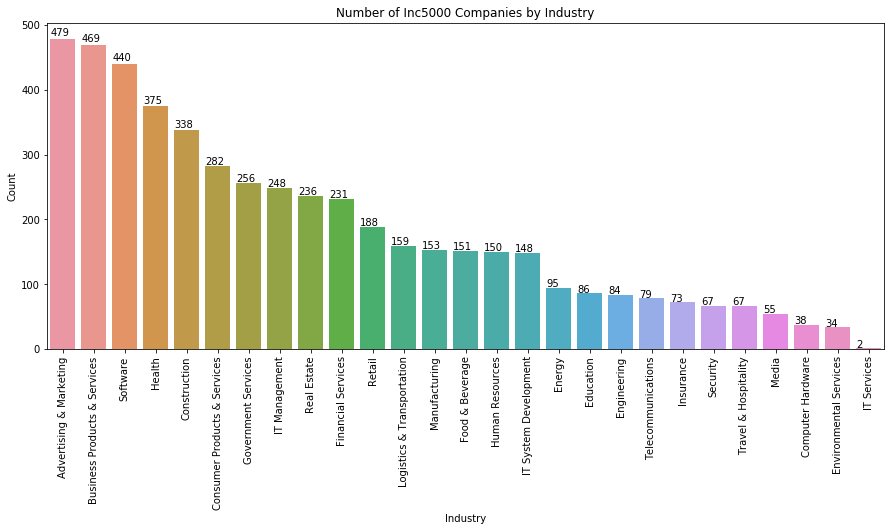

In [58]:
#Seaborn Plot
a4_dims = (15, 6)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.countplot(df2.Industry, ax = ax, order= df2.Industry.value_counts().index)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Number of Inc5000 Companies by Industry")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.01))

### Number of Companies per City (top 30)

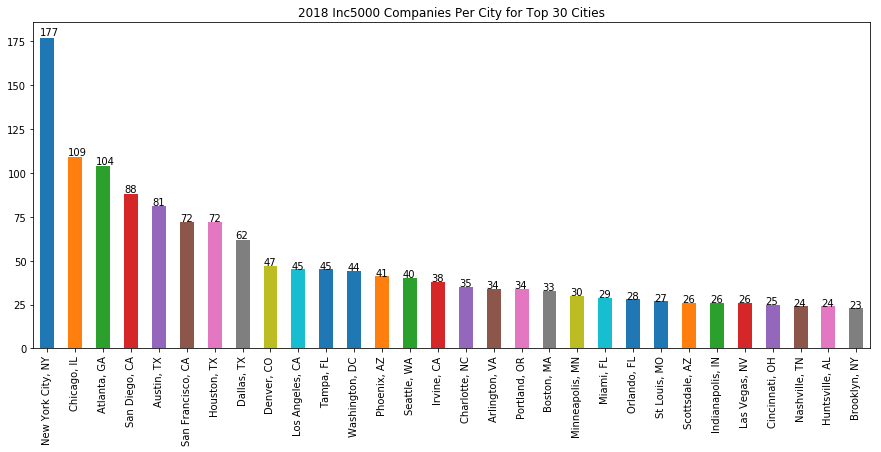

In [59]:
ax = df2.Location.value_counts().sort_values(ascending=False).head(30).plot.bar(figsize=a4_dims, title="2018 Inc5000 Companies Per City for Top 30 Cities")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.01))

### Number of Companies per State

Have to create a "State" attribute by extracting the last two characters of the "Location" attribute

In [60]:
df2['State'] = df2["Location"].apply(lambda x: x[-2:])

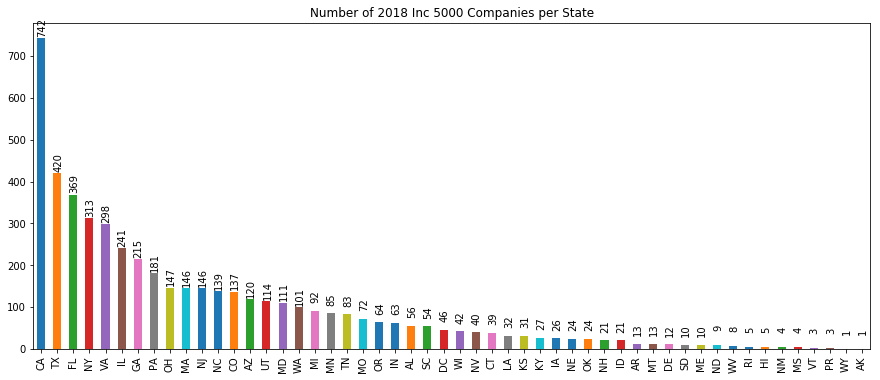

In [61]:
aa = df2.State.value_counts().plot.bar(figsize=a4_dims, title = "Number of 2018 Inc 5000 Companies per State")
for p in aa.patches:
    aa.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() + 30), rotation=90)

## Number of Employees vs Revenue Scatterplot

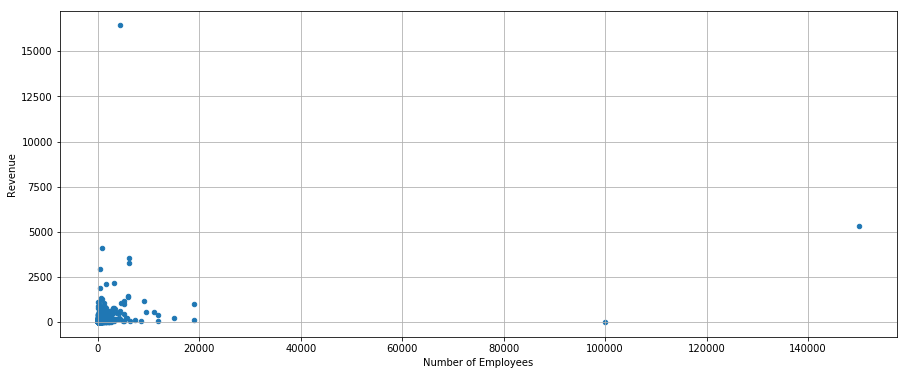

In [62]:
a4_dims = (15, 6)
fig, ax = plt.subplots(figsize=a4_dims)
df2.plot.scatter(x = "EmployeeUpdate", y = "Revenue", ax = ax)
plt.xlabel("Number of Employees")
plt.grid()

There are a few companies that look like outliers. There is one in particular that stands out a lot. The point with about 100,000 employees but close to 0 revenue. Let's take a look at this one.

In [63]:
df2[(df2.EmployeeUpdate > 90000) & (df2.EmployeeUpdate < 110000)]

,index,Rank,CompanyName,Leadership,2017Revenue,Industry,Founded,Growth,Location,Employees,Revenue,GrowthPercent,EmployeeUpdate,State
1682,1682,#1684,Alorica,Andy Lee,$2.3 M,Business Products & Services,1999,273%,"Irvine, CA",100000,2.3,273,100000,CA


Alcoria has 100,000 employees but only $2.3M in revenue. This doesn't seem right. However, as you can see in the image below, that is exactly what is provided in their Inc.com profile.

![title](Alorica.png)

### Violinplot of Revenue Per Employee Segmented by Industry

Creating a new 'Revenue Per Employee' attribute. First, there are several companies that have 0 employees in their inc5000 profile.

In [92]:
display(df2[df2.EmployeeUpdate == 0])

,index,Rank,CompanyName,Leadership,2017Revenue,Industry,Founded,Growth,Location,Employees,Revenue,GrowthPercent,EmployeeUpdate,State,RevenuePerEmployee
1973,1973,#1975,MJ Freeway,Amy Poinsett,$8.1 M,Software,2010,226%,"Denver, CO",0,8.1,226,0,CO,inf
2267,2267,#2270,Playags,David Lopez,$212 M,Business Products & Services,2005,194%,"Las Vegas, NV",0,212.0,194,0,NV,inf
2899,2899,#2902,Grand Power Systems,Stephen Paul,$29.5 M,Energy,1948,141%,"Grand Haven, MI",0,29.5,141,0,MI,inf
3158,3158,#3161,BayCom,George Guarini,$44.3 M,Financial Services,2004,125%,"Walnut Creek, CA",0,44.3,125,0,CA,inf
3434,3434,#3437,Peddle,Tim Yarosh,$65.6 M,Consumer Products & Services,2011,111%,"Austin, TX",0,65.6,111,0,TX,inf
3435,3435,#3438,E-file.com,Aaron Rosenthal and Robert Reynard,$5.1 M,Consumer Products & Services,2011,111%,"Ponte Vedra, FL",0,5.1,111,0,FL,inf
4066,4066,#4069,Bridgewater Bancshares,Jerry Baack,$52.5 M,Financial Services,2005,86%,"Bloomington, MN",0,52.5,86,0,MN,inf
4776,4776,#4778,Ellison Bakery,Todd Wallin,$29.9 M,Food & Beverage,1945,64%,"Ft. Wayne, IN",0,29.9,64,0,IN,inf
4822,4822,#4824,Quality Aluminum Products,Bob Clark,$45 M,Manufacturing,1990,63%,"Hastings, MI",0,45.0,63,0,MI,inf
4951,4951,#4953,Custom Profile,John Boeschenstein,$48.3 M,Manufacturing,1992,59%,"Grand Rapids, MI",0,48.3,59,0,MI,inf


In [93]:
df3 = df2[df2.EmployeeUpdate > 0]

And now I will create the "Revenue Per Employee" attribute and create the violin plot.

In [94]:
df3['RevenuePerEmployee'] = df3.Revenue/df3.EmployeeUpdate

C:\Users\Eila\.virtualenvs\Inc5000-fIcpwsPl\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


C:\Users\Eila\.virtualenvs\Inc5000-fIcpwsPl\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text xticklabel objects>)

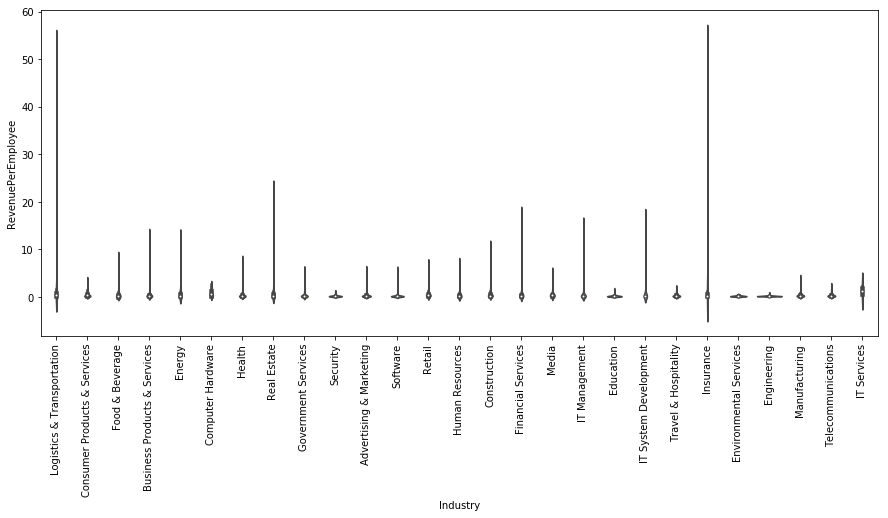

In [96]:
a4_dims = (15, 6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.violinplot(data = df3, ax = ax, x = "Industry", y = "RevenuePerEmployee")
plt.xticks(rotation=90)

## Tables

### Revenue Statistics Segmented by Industry

In [73]:
df2[df2.Revenue > 0].groupby("Industry").agg(['mean', 'std', 'count', 'max', 'min', 'sum']).RevenuePerEmployee.sort_values(by="mean", ascending = False)

,mean,std,count,max,min,sum
Industry,,,,,,
IT Services,2.866565,3.045686,3,6.137500,0.112195,8.599695
Insurance,1.253201,6.083301,73,52.086667,0.014555,91.483644
Logistics & Transportation,0.954087,4.275204,157,53.100000,0.007678,149.791639
Computer Hardware,0.835127,0.710134,37,2.676190,0.035632,30.899710
Energy,0.732420,1.750546,92,12.800000,0.056688,67.382653
Real Estate,0.679383,1.919985,236,23.183333,0.010160,160.334295
Retail,0.612561,0.846923,186,7.341667,0.019454,113.936368
Construction,0.554232,0.955006,332,11.237500,0.035013,184.005000
Consumer Products & Services,0.497132,0.547705,276,3.830769,0.018667,137.208357


### Growth Statistics Segmented by Industry (%)

In [50]:
df2[df2.GrowthPercent > 0].groupby('Industry').agg(['mean', 'std', 'count', 'max', 'min', 'sum'])['GrowthPercent'].sort_values(by='mean', ascending=False)

,mean,std,count,max,min,sum
Industry,,,,,,
Logistics & Transportation,1168.509434,6336.839820,159,75661,57,185793
Energy,1069.010526,4061.186239,95,38963,57,101556
Computer Hardware,993.815789,3285.066233,38,19718,57,37765
Food & Beverage,871.933775,4947.975299,151,60166,58,131662
Consumer Products & Services,805.230496,4352.807628,282,71424,58,227075
Retail,738.882979,1497.290007,188,10924,58,138910
Media,706.781818,986.464519,55,5686,59,38873
Government Services,659.203125,1510.899609,256,14476,57,168756
Security,628.283582,1910.105842,67,14032,60,42095
